# Base experiment notebook

This notebook is the template for all experiments.

It contains the basic code to run an experiment, and it is the starting point for all other notebooks in the folder `experiments`.

## Setup and Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [13]:
import json
from pathlib import Path

import pytorch_lightning as pl
import torch
from pytorch_lightning import callbacks, seed_everything
from torch import nn

from nlp_assemblee.simple_datasets import AssembleeDataset
from nlp_assemblee.simple_trainer import LitModel, load_embedding, process_predictions
from nlp_assemblee.simple_visualisation import (
    calculate_metrics,
    calculate_metrics_binary,
    plot_confusion_matrix,
    plot_network_graph,
    plot_precision_recall_curve,
    plot_precision_recall_curve_binary,
    plot_roc_curve,
    plot_roc_curve_binary,
)

In [3]:
seed_everything(42, workers=True)

device = "cuda" if torch.cuda.is_available() else "cpu"
device

Global seed set to 42


'cuda'

## Definition of the notebook variables

In [4]:
# To change between experiments
FEATURES = True
TEXT_VARS = ["intervention", "titre_regexed", "contexte"]

BATCH_SIZE = 512
MAX_EPOCHS = 100

CALLBACKS = [
    callbacks.EarlyStopping(
        monitor="val_loss",
        mode="min",
        min_delta=0.005,
        check_finite=True,
        patience=10,
        verbose=True,
    ),
    callbacks.ModelSummary(max_depth=-1),
    callbacks.Timer(duration="00:03:00:00", interval="epoch"),
    callbacks.RichProgressBar(
        theme=callbacks.progress.rich_progress.RichProgressBarTheme(
            description="green_yellow", progress_bar="green1"
        )
    ),
    callbacks.LearningRateMonitor(logging_interval="epoch", log_momentum=False),
    callbacks.ModelCheckpoint(
        monitor="val_loss",
        mode="min",
        save_top_k=1,
        verbose=True,
        save_last=True,
    ),
]

OPTIMIZER_TYPE = "Adam"
OPTIMIZER_KWARGS = {"weight_decay": 1e-4}
LR = 5e-3
LOSS = "CrossEntropyLoss"

SCHEDULER_KWARGS = {
    "scheduler": "ReduceLROnPlateau",
    "mode": "min",
    "factor": 0.1,
    "patience": 3,
    "interval": "epoch",
    "frequency": 1,
    "strict": True,
    "monitor": "val_loss",
}
# SCHEDULER_KWARGS = {
#     "scheduler": "OneCycleLR",
#     "max_lr": 5e-3,
#     "pct_start": 0.3,
#     "epochs": 30,
#     "steps_per_epoch": 100,
#     "interval": "epoch",
#     "frequency": 1,
#     "strict": True
# }


# Doesn't change between experiments
LABEL_VAR = "label"
DATA_ROOT = "../../data/"
NUM_WORKERS = 12
PREFETCH_FACTOR = 4
PIN_MEMORY = True
ACCELERATOR = "gpu"
DEVICE = "cuda"
LOG_EVERY_N_STEPS = 50
CHECK_VAL_EVERY_N_EPOCH = 1
DETERMINISTIC = False

## CamemBERT base

In [5]:
### Experiment definition
MODEL_NAME = "camembert-base"
MODEL_FOLDER = f"../../data/precomputed/{MODEL_NAME}"
RESULTS_PATH = f"../../results/lm_model_selection/{MODEL_NAME}/"
LOGGER = pl.loggers.TensorBoardLogger(RESULTS_PATH, log_graph=False)
Path(RESULTS_PATH).mkdir(parents=True, exist_ok=True)


### Definition of the net architecture
class Net(nn.Module):
    def __init__(self, root, embed_dim, inter_dim, dropout=0.2, freeze=True):
        super().__init__()
        self.example_input_array = {
            "text": {
                "intervention": torch.randn(32, 768),
                "titre_regexed": torch.randint(100, (32,)).int(),
                "contexte": torch.randint(100, (32,)).int(),
            }
        }

        self.embed_dim = embed_dim
        self.inter_dim = inter_dim
        self.dropout = dropout
        self.freeze = freeze

        self.titre_embeddings = load_embedding(root, "titre_regexed", freeze=freeze)
        self.titre_fc = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(embed_dim, inter_dim),
            nn.GELU(),
        )

        self.contexte_embeddings = load_embedding(root, "contexte", freeze=freeze)
        self.contexte_fc = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(embed_dim, inter_dim),
            nn.GELU(),
        )

        self.intervention_fc = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(embed_dim, inter_dim),
            nn.GELU(),
        )

        self.mlp = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(inter_dim, inter_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(inter_dim, 3),
        )

    def forward(self, **x):
        intervention = x["text"]["intervention"]
        titre_regexed = x["text"]["titre_regexed"]
        contexte = x["text"]["contexte"]

        intervention_repr = self.intervention_fc(intervention)

        titre_emb = self.titre_embeddings(titre_regexed)
        titre_repr = self.titre_fc(titre_emb)

        contexte_emb = self.contexte_embeddings(contexte)
        contexte_repr = self.contexte_fc(contexte_emb)

        pooled_repr = intervention_repr + titre_repr + contexte_repr

        logits = self.mlp(pooled_repr)

        return logits


NET = Net(MODEL_FOLDER, 768, 768, dropout=0.2, freeze=True)

### Definition of the trainer and module
lit_model = LitModel(
    NET,
    optimizer_type=OPTIMIZER_TYPE,
    learning_rate=LR,
    optimizer_kwargs=OPTIMIZER_KWARGS,
    scheduler_kwargs=SCHEDULER_KWARGS,
    criterion_type=LOSS,
    batch_size=BATCH_SIZE,
    loader_kwargs={
        "root": MODEL_FOLDER,
        "text_vars": TEXT_VARS,
        "use_features": FEATURES,
        "label_var": LABEL_VAR,
        "num_workers": NUM_WORKERS,
        "prefetch_factor": PREFETCH_FACTOR,
        "pin_memory": PIN_MEMORY,
    },
)

trainer = pl.Trainer(
    accelerator=ACCELERATOR,
    max_epochs=MAX_EPOCHS,
    logger=LOGGER,
    callbacks=CALLBACKS,
    deterministic=DETERMINISTIC,
    log_every_n_steps=LOG_EVERY_N_STEPS,
    check_val_every_n_epoch=CHECK_VAL_EVERY_N_EPOCH,
)

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


### Training

In [6]:
trainer.fit(lit_model);

Missing logger folder: ../../results/lm_model_selection/camembert-base/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                           | Type       | Params | In sizes  | Out sizes
---------------------------------------------------------------------------------------
0  | classifier                     | Net        | 6.6 M  | ?         | [32, 3]  
1  | classifier.titre_embeddings    | Embedding  | 3.9 M  | [32]      | [32, 768]
2  | classifier.titre_fc            | Sequential | 590 K  | [32, 768] | [32, 768]
3  | classifier.titre_fc.0          | Dropout    | 0      | [32, 768] | [32, 768]
4  | classifier.titre_fc.1          | Linear     | 590 K  | [32, 768] | [32, 768]
5  | classifier.titre_fc.2          | GELU       | 0      | [32, 768] | [32, 768]
6  | classifier.contexte_embeddings | Embedding  | 363 K  | [32]      | [32, 768]
7  | classifier.contexte_fc         | Sequential | 590 K  | [32, 768] | [32, 768]
8  | classifier.contexte_fc.0       | Dropout

Output()

Metric val_loss improved. New best score: 0.884
Epoch 0, global step 1421: 'val_loss' reached 0.88380 (best 0.88380), saving model to '../../results/lm_model_selection/camembert-base/lightning_logs/version_0/checkpoints/epoch=0-step=1421.ckpt' as top 1


Metric val_loss improved by 0.012 >= min_delta = 0.005. New best score: 0.872
Epoch 1, global step 2842: 'val_loss' reached 0.87181 (best 0.87181), saving model to '../../results/lm_model_selection/camembert-base/lightning_logs/version_0/checkpoints/epoch=1-step=2842.ckpt' as top 1


Epoch 2, global step 4263: 'val_loss' reached 0.87032 (best 0.87032), saving model to '../../results/lm_model_selection/camembert-base/lightning_logs/version_0/checkpoints/epoch=2-step=4263.ckpt' as top 1


Epoch 3, global step 5684: 'val_loss' reached 0.86743 (best 0.86743), saving model to '../../results/lm_model_selection/camembert-base/lightning_logs/version_0/checkpoints/epoch=3-step=5684.ckpt' as top 1


Epoch 4, global step 7105: 'val_loss' was not in top 1


Metric val_loss improved by 0.009 >= min_delta = 0.005. New best score: 0.863
Epoch 5, global step 8526: 'val_loss' reached 0.86278 (best 0.86278), saving model to '../../results/lm_model_selection/camembert-base/lightning_logs/version_0/checkpoints/epoch=5-step=8526.ckpt' as top 1


Epoch 6, global step 9947: 'val_loss' was not in top 1


Epoch 7, global step 11368: 'val_loss' was not in top 1


Epoch 8, global step 12789: 'val_loss' was not in top 1


Epoch 9, global step 14210: 'val_loss' was not in top 1


Metric val_loss improved by 0.031 >= min_delta = 0.005. New best score: 0.831
Epoch 10, global step 15631: 'val_loss' reached 0.83143 (best 0.83143), saving model to '../../results/lm_model_selection/camembert-base/lightning_logs/version_0/checkpoints/epoch=10-step=15631.ckpt' as top 1


Metric val_loss improved by 0.007 >= min_delta = 0.005. New best score: 0.824
Epoch 11, global step 17052: 'val_loss' reached 0.82407 (best 0.82407), saving model to '../../results/lm_model_selection/camembert-base/lightning_logs/version_0/checkpoints/epoch=11-step=17052.ckpt' as top 1


Epoch 12, global step 18473: 'val_loss' reached 0.82175 (best 0.82175), saving model to '../../results/lm_model_selection/camembert-base/lightning_logs/version_0/checkpoints/epoch=12-step=18473.ckpt' as top 1


Metric val_loss improved by 0.007 >= min_delta = 0.005. New best score: 0.817
Epoch 13, global step 19894: 'val_loss' reached 0.81667 (best 0.81667), saving model to '../../results/lm_model_selection/camembert-base/lightning_logs/version_0/checkpoints/epoch=13-step=19894.ckpt' as top 1


Epoch 14, global step 21315: 'val_loss' reached 0.81358 (best 0.81358), saving model to '../../results/lm_model_selection/camembert-base/lightning_logs/version_0/checkpoints/epoch=14-step=21315.ckpt' as top 1


Epoch 15, global step 22736: 'val_loss' reached 0.81193 (best 0.81193), saving model to '../../results/lm_model_selection/camembert-base/lightning_logs/version_0/checkpoints/epoch=15-step=22736.ckpt' as top 1


Metric val_loss improved by 0.008 >= min_delta = 0.005. New best score: 0.809
Epoch 16, global step 24157: 'val_loss' reached 0.80890 (best 0.80890), saving model to '../../results/lm_model_selection/camembert-base/lightning_logs/version_0/checkpoints/epoch=16-step=24157.ckpt' as top 1


Epoch 17, global step 25578: 'val_loss' was not in top 1


Epoch 18, global step 26999: 'val_loss' reached 0.80805 (best 0.80805), saving model to '../../results/lm_model_selection/camembert-base/lightning_logs/version_0/checkpoints/epoch=18-step=26999.ckpt' as top 1


Epoch 19, global step 28420: 'val_loss' was not in top 1


Epoch 20, global step 29841: 'val_loss' reached 0.80617 (best 0.80617), saving model to '../../results/lm_model_selection/camembert-base/lightning_logs/version_0/checkpoints/epoch=20-step=29841.ckpt' as top 1


Epoch 21, global step 31262: 'val_loss' was not in top 1


Epoch 22, global step 32683: 'val_loss' was not in top 1


Epoch 23, global step 34104: 'val_loss' was not in top 1


Metric val_loss improved by 0.007 >= min_delta = 0.005. New best score: 0.802
Epoch 24, global step 35525: 'val_loss' reached 0.80163 (best 0.80163), saving model to '../../results/lm_model_selection/camembert-base/lightning_logs/version_0/checkpoints/epoch=24-step=35525.ckpt' as top 1


Epoch 25, global step 36946: 'val_loss' was not in top 1


Epoch 26, global step 38367: 'val_loss' was not in top 1


Epoch 27, global step 39788: 'val_loss' was not in top 1


Epoch 28, global step 41209: 'val_loss' reached 0.79898 (best 0.79898), saving model to '../../results/lm_model_selection/camembert-base/lightning_logs/version_0/checkpoints/epoch=28-step=41209.ckpt' as top 1


Epoch 29, global step 42630: 'val_loss' was not in top 1


Epoch 30, global step 44051: 'val_loss' was not in top 1


Metric val_loss improved by 0.006 >= min_delta = 0.005. New best score: 0.796
Epoch 31, global step 45472: 'val_loss' reached 0.79597 (best 0.79597), saving model to '../../results/lm_model_selection/camembert-base/lightning_logs/version_0/checkpoints/epoch=31-step=45472.ckpt' as top 1


Epoch 32, global step 46893: 'val_loss' was not in top 1


Epoch 33, global step 48314: 'val_loss' was not in top 1


Epoch 34, global step 49735: 'val_loss' was not in top 1


Epoch 35, global step 51156: 'val_loss' was not in top 1


Metric val_loss improved by 0.007 >= min_delta = 0.005. New best score: 0.789
Epoch 36, global step 52577: 'val_loss' reached 0.78916 (best 0.78916), saving model to '../../results/lm_model_selection/camembert-base/lightning_logs/version_0/checkpoints/epoch=36-step=52577.ckpt' as top 1


Epoch 37, global step 53998: 'val_loss' reached 0.78866 (best 0.78866), saving model to '../../results/lm_model_selection/camembert-base/lightning_logs/version_0/checkpoints/epoch=37-step=53998.ckpt' as top 1


Epoch 38, global step 55419: 'val_loss' reached 0.78844 (best 0.78844), saving model to '../../results/lm_model_selection/camembert-base/lightning_logs/version_0/checkpoints/epoch=38-step=55419.ckpt' as top 1


Epoch 39, global step 56840: 'val_loss' reached 0.78839 (best 0.78839), saving model to '../../results/lm_model_selection/camembert-base/lightning_logs/version_0/checkpoints/epoch=39-step=56840.ckpt' as top 1


Epoch 40, global step 58261: 'val_loss' reached 0.78720 (best 0.78720), saving model to '../../results/lm_model_selection/camembert-base/lightning_logs/version_0/checkpoints/epoch=40-step=58261.ckpt' as top 1


Epoch 41, global step 59682: 'val_loss' was not in top 1


Epoch 42, global step 61103: 'val_loss' reached 0.78711 (best 0.78711), saving model to '../../results/lm_model_selection/camembert-base/lightning_logs/version_0/checkpoints/epoch=42-step=61103.ckpt' as top 1


Epoch 43, global step 62524: 'val_loss' reached 0.78711 (best 0.78711), saving model to '../../results/lm_model_selection/camembert-base/lightning_logs/version_0/checkpoints/epoch=43-step=62524.ckpt' as top 1


Epoch 44, global step 63945: 'val_loss' reached 0.78661 (best 0.78661), saving model to '../../results/lm_model_selection/camembert-base/lightning_logs/version_0/checkpoints/epoch=44-step=63945.ckpt' as top 1


Epoch 45, global step 65366: 'val_loss' was not in top 1


Monitored metric val_loss did not improve in the last 10 records. Best score: 0.789. Signaling Trainer to stop.
Epoch 46, global step 66787: 'val_loss' reached 0.78580 (best 0.78580), saving model to '../../results/lm_model_selection/camembert-base/lightning_logs/version_0/checkpoints/epoch=46-step=66787.ckpt' as top 1


### Evaluation and visualization

Restoring states from the checkpoint path at ../../results/lm_model_selection/camembert-base/lightning_logs/version_0/checkpoints/epoch=46-step=66787.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at ../../results/lm_model_selection/camembert-base/lightning_logs/version_0/checkpoints/epoch=46-step=66787.ckpt


Output()

Metrics:  {'log_loss': 0.7819652861936575, 'accuracy': 0.642135470148159, 'balanced_accuracy': 0.5164786722489314, 'recall_weighted': 0.642135470148159, 'recall_micro': 0.642135470148159, 'recall_macro': 0.5164786722489314, 'precision_weighted': 0.6370006122773173, 'precision_micro': 0.642135470148159, 'precision_macro': 0.6281713525855175, 'f1_score_weighted': 0.6138084318566877, 'f1_score_micro': 0.642135470148159, 'f1_score_macro': 0.519492065263448, 'AUC_weighted_ovr': 0.7857361119238075, 'AUC_macro_ovr': 0.7846256591389089, 'AUC_weighted_ovo': 0.7783972171237793, 'AUC_macro_ovo': 0.7756037793064986, 'jaccard_weighted': 0.46016962273906314, 'jaccard_micro': 0.4729009824111272, 'jaccard_macro': 0.37824311206741296, 'matthews_weighted': 0.37115462487781603, 'hamming_loss': 0.357864529851841, 'confusion_matrix': [[44263, 813, 9469], [9423, 2029, 3841], [14940, 547, 23747]], 'confusion_matrix_true_normed': [[0.8114950957924649, 0.014905124209368412, 0.17359977999816664], [0.61616425815

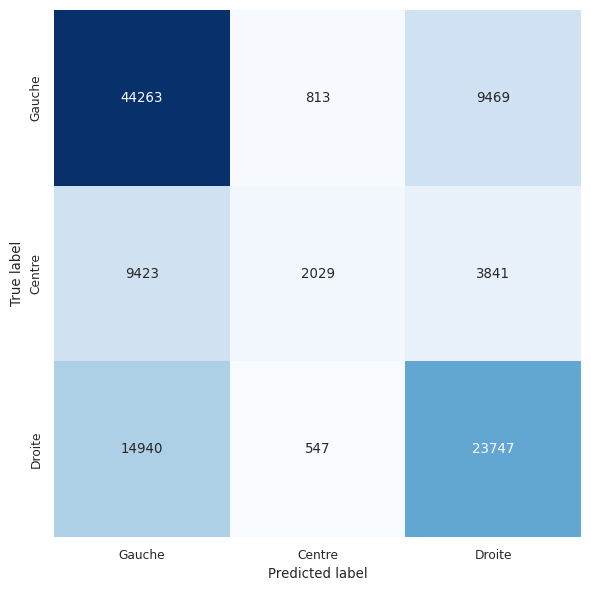

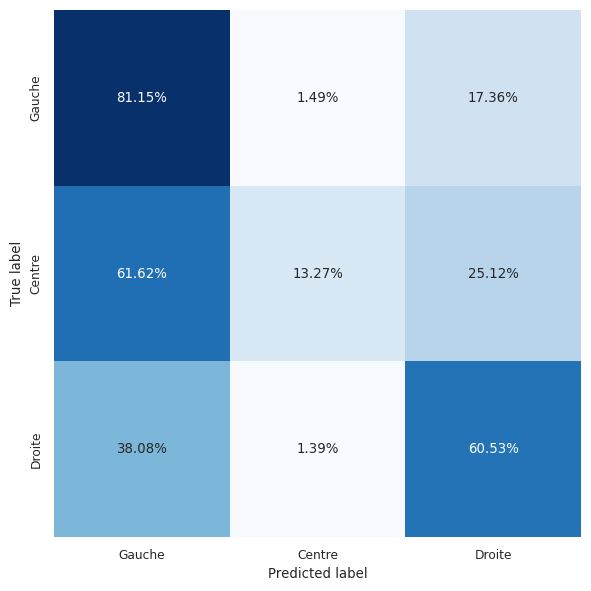

Micro-averaged One-vs-Rest ROC AUC score:
0.83
Macro-averaged One-vs-Rest ROC AUC score:
0.78


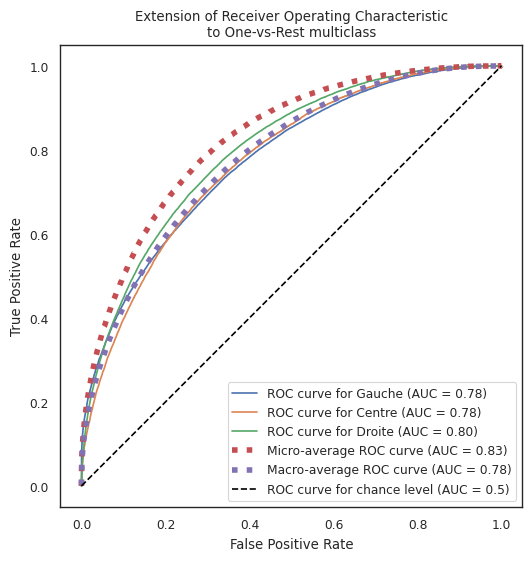

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


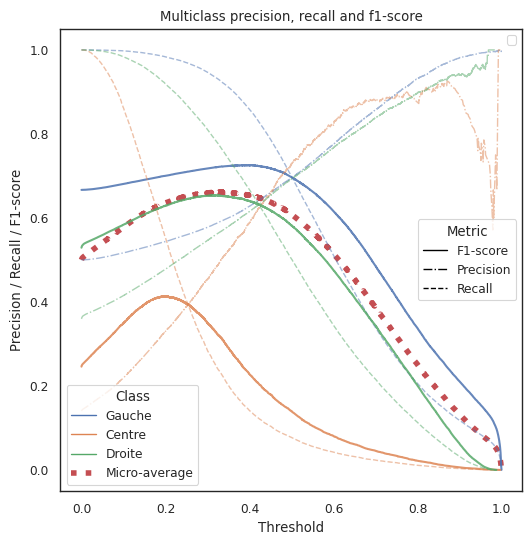

In [7]:
#### Prediction on test set
preds = trainer.predict(ckpt_path="best")


#### Metrics and logs
results = process_predictions(preds)

metrics = calculate_metrics(results)
print("Metrics: ", metrics)

with open(Path(RESULTS_PATH) / "metrics.json", "w") as f:
    json.dump(metrics, f)

logs_dict = {
    "last_epoch": trainer.current_epoch,
    "log_dir": trainer.log_dir,
    "ckpt_path": trainer.ckpt_path,
    "total_parameters": pl.utilities.model_summary.summarize(lit_model).total_parameters,
    "trainable_parameters": pl.utilities.model_summary.summarize(lit_model).trainable_parameters,
    "model_size": pl.utilities.model_summary.summarize(lit_model).model_size,
    "hparams": dict(lit_model.hparams_initial),
    "time_elapsed": trainer.callbacks[2].time_elapsed(),
    "metrics": metrics,
}

with open(Path(RESULTS_PATH) / "logs.json", "w") as f:
    json.dump(logs_dict, f)


#### Plots
confusion_fig = plot_confusion_matrix(results, figsize=(6, 6), normalized=None)
confusion_fig.savefig(Path(RESULTS_PATH) / "confusion_matrix.png")

confusion_true_fig = plot_confusion_matrix(results, figsize=(6, 6), normalized="true")
confusion_true_fig.savefig(Path(RESULTS_PATH) / "confusion_matrix_true_normed.png")

roc_fig = plot_roc_curve(results, figsize=(6, 6), palette="deep")
roc_fig.savefig(Path(RESULTS_PATH) / "roc_curve.png")

pr_fig = plot_precision_recall_curve(results, figsize=(6, 6), palette="deep")
pr_fig.savefig(Path(RESULTS_PATH) / "precision_recall_curve.png")

network_fig = plot_network_graph(NET, device=DEVICE, model_name=MODEL_NAME, path=RESULTS_PATH)

## CamemBERT base binary

In [9]:
### Experiment definition
MODEL_NAME = "camembert-base"
MODEL_FOLDER = f"../../data/precomputed/{MODEL_NAME}"
RESULTS_PATH = f"../../results/lm_model_selection/{MODEL_NAME}_binary"
LOGGER = pl.loggers.TensorBoardLogger(RESULTS_PATH, log_graph=False)
Path(RESULTS_PATH).mkdir(parents=True, exist_ok=True)
DROP_CENTER = True


### Definition of the net architecture
class Net(nn.Module):
    def __init__(self, root, embed_dim, inter_dim, dropout=0.2, freeze=True):
        super().__init__()
        self.example_input_array = {
            "text": {
                "intervention": torch.randn(32, 768),
                "titre_regexed": torch.randint(100, (32,)).int(),
                "contexte": torch.randint(100, (32,)).int(),
            }
        }

        self.embed_dim = embed_dim
        self.inter_dim = inter_dim
        self.dropout = dropout
        self.freeze = freeze

        self.titre_embeddings = load_embedding(root, "titre_regexed", freeze=freeze)
        self.titre_fc = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(embed_dim, inter_dim),
            nn.GELU(),
        )

        self.contexte_embeddings = load_embedding(root, "contexte", freeze=freeze)
        self.contexte_fc = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(embed_dim, inter_dim),
            nn.GELU(),
        )

        self.intervention_fc = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(embed_dim, inter_dim),
            nn.GELU(),
        )

        self.mlp = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(inter_dim, inter_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(inter_dim, 2),
        )

    def forward(self, **x):
        intervention = x["text"]["intervention"]
        titre_regexed = x["text"]["titre_regexed"]
        contexte = x["text"]["contexte"]

        intervention_repr = self.intervention_fc(intervention)

        titre_emb = self.titre_embeddings(titre_regexed)
        titre_repr = self.titre_fc(titre_emb)

        contexte_emb = self.contexte_embeddings(contexte)
        contexte_repr = self.contexte_fc(contexte_emb)

        pooled_repr = intervention_repr + titre_repr + contexte_repr

        logits = self.mlp(pooled_repr)

        return logits


NET = Net(MODEL_FOLDER, 768, 768, dropout=0.2, freeze=True)

### Definition of the trainer and module
lit_model = LitModel(
    NET,
    optimizer_type=OPTIMIZER_TYPE,
    learning_rate=LR,
    optimizer_kwargs=OPTIMIZER_KWARGS,
    scheduler_kwargs=SCHEDULER_KWARGS,
    criterion_type=LOSS,
    batch_size=BATCH_SIZE,
    loader_kwargs={
        "root": MODEL_FOLDER,
        "text_vars": TEXT_VARS,
        "use_features": FEATURES,
        "label_var": LABEL_VAR,
        "drop_center": DROP_CENTER,
        "num_workers": NUM_WORKERS,
        "prefetch_factor": PREFETCH_FACTOR,
        "pin_memory": PIN_MEMORY,
    },
)

trainer = pl.Trainer(
    accelerator=ACCELERATOR,
    max_epochs=MAX_EPOCHS,
    logger=LOGGER,
    callbacks=CALLBACKS,
    deterministic=DETERMINISTIC,
    log_every_n_steps=LOG_EVERY_N_STEPS,
    check_val_every_n_epoch=CHECK_VAL_EVERY_N_EPOCH,
)

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


### Training

In [11]:
trainer.fit(lit_model);

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                           | Type       | Params | In sizes  | Out sizes
---------------------------------------------------------------------------------------
0  | classifier                     | Net        | 6.6 M  | ?         | [32, 2]  
1  | classifier.titre_embeddings    | Embedding  | 3.9 M  | [32]      | [32, 768]
2  | classifier.titre_fc            | Sequential | 590 K  | [32, 768] | [32, 768]
3  | classifier.titre_fc.0          | Dropout    | 0      | [32, 768] | [32, 768]
4  | classifier.titre_fc.1          | Linear     | 590 K  | [32, 768] | [32, 768]
5  | classifier.titre_fc.2          | GELU       | 0      | [32, 768] | [32, 768]
6  | classifier.contexte_embeddings | Embedding  | 363 K  | [32]      | [32, 768]
7  | classifier.contexte_fc         | Sequential | 590 K  | [32, 768] | [32, 768]
8  | classifier.contexte_fc.0       | Dropout    | 0      | [32, 768] | [32, 768]
9  | classifier.contexte_fc.1       | Linear     

Output()

Metric val_loss improved by 0.146 >= min_delta = 0.005. New best score: 0.644
Epoch 0, global step 1222: 'val_loss' reached 0.64357 (best 0.64357), saving model to '../../results/lm_model_selection/camembert-base/lightning_logs/version_0/checkpoints/epoch=0-step=1222.ckpt' as top 1


Metric val_loss improved by 0.018 >= min_delta = 0.005. New best score: 0.626
Epoch 1, global step 2444: 'val_loss' reached 0.62577 (best 0.62577), saving model to '../../results/lm_model_selection/camembert-base/lightning_logs/version_0/checkpoints/epoch=1-step=2444.ckpt' as top 1


Metric val_loss improved by 0.052 >= min_delta = 0.005. New best score: 0.574
Epoch 2, global step 3666: 'val_loss' reached 0.57395 (best 0.57395), saving model to '../../results/lm_model_selection/camembert-base/lightning_logs/version_0/checkpoints/epoch=2-step=3666.ckpt' as top 1


Epoch 3, global step 4888: 'val_loss' was not in top 1


Epoch 4, global step 6110: 'val_loss' was not in top 1


Epoch 5, global step 7332: 'val_loss' reached 0.57356 (best 0.57356), saving model to '../../results/lm_model_selection/camembert-base/lightning_logs/version_0/checkpoints/epoch=5-step=7332.ckpt' as top 1


Epoch 6, global step 8554: 'val_loss' was not in top 1


Metric val_loss improved by 0.005 >= min_delta = 0.005. New best score: 0.569
Epoch 7, global step 9776: 'val_loss' reached 0.56893 (best 0.56893), saving model to '../../results/lm_model_selection/camembert-base/lightning_logs/version_0/checkpoints/epoch=7-step=9776.ckpt' as top 1


Epoch 8, global step 10998: 'val_loss' reached 0.56546 (best 0.56546), saving model to '../../results/lm_model_selection/camembert-base/lightning_logs/version_0/checkpoints/epoch=8-step=10998.ckpt' as top 1


Epoch 9, global step 12220: 'val_loss' was not in top 1


Epoch 10, global step 13442: 'val_loss' was not in top 1


Epoch 11, global step 14664: 'val_loss' was not in top 1


Epoch 12, global step 15886: 'val_loss' was not in top 1


Epoch 13, global step 17108: 'val_loss' was not in top 1


Epoch 14, global step 18330: 'val_loss' was not in top 1


Epoch 15, global step 19552: 'val_loss' was not in top 1


Epoch 16, global step 20774: 'val_loss' was not in top 1


Monitored metric val_loss did not improve in the last 10 records. Best score: 0.569. Signaling Trainer to stop.
Epoch 17, global step 21996: 'val_loss' was not in top 1


### Evaluation and visualization

Restoring states from the checkpoint path at ../../results/lm_model_selection/camembert-base/lightning_logs/version_0/checkpoints/epoch=8-step=10998.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at ../../results/lm_model_selection/camembert-base/lightning_logs/version_0/checkpoints/epoch=8-step=10998.ckpt


Output()

Metrics:  {'log_loss': 0.5632251511846481, 'accuracy': 0.7013723754785186, 'balanced_accuracy': 0.6842812842372912, 'recall': 0.5795993271142377, 'precision': 0.6639222212490147, 'f1_score': 0.6189018166972852, 'AUC': 0.7679360257688984, 'jaccard_weighted': 0.4481229677800769, 'matthews_weighted': 0.37759194322623474, 'hamming_loss': 0.29862762452148134, 'confusion_matrix': [[43034, 11511], [16494, 22740]], 'confusion_matrix_true_normed': [[0.7889632413603447, 0.21103675863965532], [0.4204006728857623, 0.5795993271142377]], 'confusion_matrix_pred_normed': [[0.7229203064104287, 0.3360777787509854], [0.2770796935895713, 0.6639222212490147]], 'confusion_matrix_all_normed': [[0.4588873841691637, 0.12274603056121307], [0.17588159396026828, 0.24248499130935497]]}


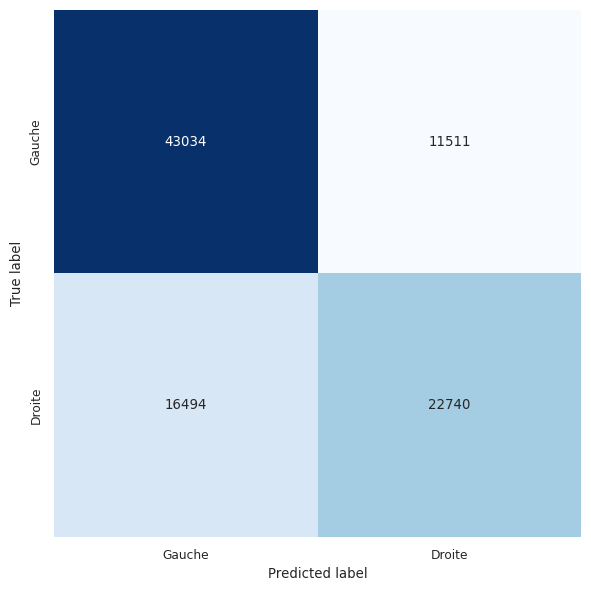

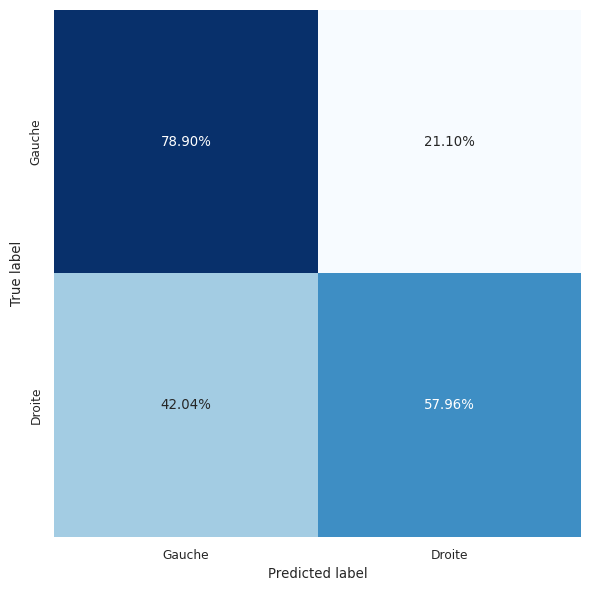

NameError: name 'roc_auc' is not defined

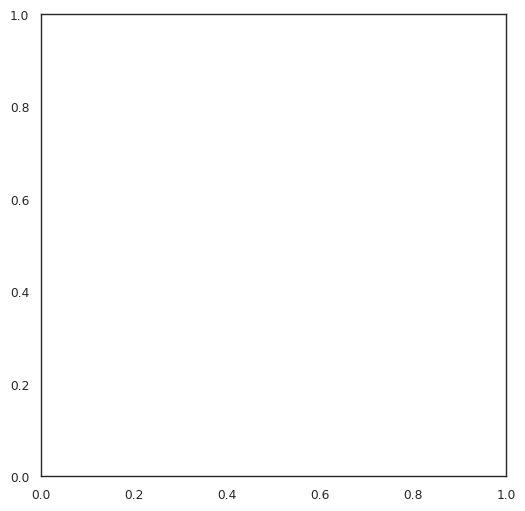

In [22]:
#### Prediction on test set
preds = trainer.predict(ckpt_path="best")


#### Metrics and logs
results = process_predictions(preds)

metrics = calculate_metrics_binary(results)
print("Metrics: ", metrics)

with open(Path(RESULTS_PATH) / "metrics.json", "w") as f:
    json.dump(metrics, f)

logs_dict = {
    "last_epoch": trainer.current_epoch,
    "log_dir": trainer.log_dir,
    "ckpt_path": trainer.ckpt_path,
    "total_parameters": pl.utilities.model_summary.summarize(lit_model).total_parameters,
    "trainable_parameters": pl.utilities.model_summary.summarize(lit_model).trainable_parameters,
    "model_size": pl.utilities.model_summary.summarize(lit_model).model_size,
    "hparams": dict(lit_model.hparams_initial),
    "time_elapsed": trainer.callbacks[2].time_elapsed(),
    "metrics": metrics,
}

with open(Path(RESULTS_PATH) / "logs.json", "w") as f:
    json.dump(logs_dict, f)


#### Plots
confusion_fig = plot_confusion_matrix(results, figsize=(6, 6), normalized=None)
confusion_fig.savefig(Path(RESULTS_PATH) / "confusion_matrix.png")

confusion_true_fig = plot_confusion_matrix(results, figsize=(6, 6), normalized="true")
confusion_true_fig.savefig(Path(RESULTS_PATH) / "confusion_matrix_true_normed.png")

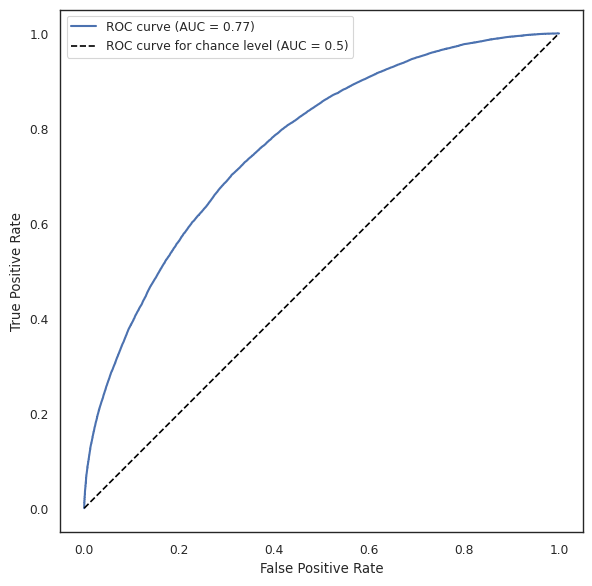

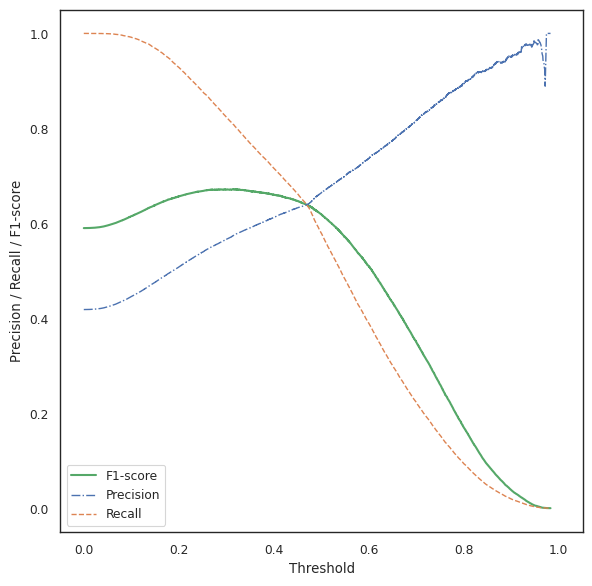

In [27]:
roc_fig = plot_roc_curve_binary(results, figsize=(6, 6), palette="deep")
roc_fig.savefig(Path(RESULTS_PATH) / "roc_curve.png")

pr_fig = plot_precision_recall_curve_binary(results, figsize=(6, 6), palette="deep")
pr_fig.savefig(Path(RESULTS_PATH) / "precision_recall_curve.png")

network_fig = plot_network_graph(NET, device=DEVICE, model_name=MODEL_NAME, path=RESULTS_PATH)